In [112]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
import seaborn as sns

In [142]:
class BanditStepData:
    def __init__(self, eps, ra_num, tr_num):
        self.eps = eps
        self.ra_num = ra_num
        self.tr_num = tr_num
        self.overal_running_avg = 0
        self.overal_total_reward = 0
        
    @classmethod
    def createDataDictForSteps(cls, step_breaks):
        return {
        step_breaks[0] : BanditStepData(0,0,0),
#         step_breaks[1] : BanditStepData(0,0,0),
#         step_breaks[2] : BanditStepData(0,0,0),
#         step_breaks[3] : BanditStepData(0,0,0)
        }
        


class AdBandit:
    def __init__(self, ads):
        self.ads = ads
        self.running_avg = 0
        self.total_reward = 0
        self.times_played = 0
        
    def show(self,index):
        # return random results with normal distribution with variance of 1, using the average reward as the mean
        return self.ads[index]
    
    def update(self, nr):
        self.times_played += 1
        self.total_reward += nr
        self.running_avg += (nr - self.running_avg) / self.times_played
        
# create bandit class
class Bandit:
    def __init__(self, r):
        self.r_dist = r
        self.running_avg = 0
        self.total_reward = 0
        self.times_played = 0
        
    def play(self):
        # return random results with normal distribution with variance of 1, using the average reward as the mean
        return np.random.normal(self.r_dist, 1)
    
    def update(self, nr):
        self.times_played += 1
        self.total_reward += nr
        self.running_avg += (nr - self.running_avg) / self.times_played

# create environment where bandits are played 
class Environment:
    def __init__(self, eps, steps, breaks):
        self.steps = steps
        self.step_breaks = breaks
        self.eps = eps
    
    def run(self, bandits): 
        total_mean = 0
        rewards = np.zeros(self.steps)
        optimal_selected = np.zeros(self.steps)
        
        step_data_dict = {
            self.step_breaks[0] : None,
#             self.step_breaks[1] : None,
#             self.step_breaks[2] : None,
#             self.step_breaks[3] : None
        }
        
        for i in range(self.steps):             
            if self.eps == -1.0 and i == 0:
                # kick off the greedy bandit
                index = np.random.choice(10)
            elif np.random.rand() < self.eps:
                # explore, pick a random bandit
                index = np.random.choice(10)
            else:
                #exploit, choose bandit with best average outcome so far
                index = np.argmax([b.running_avg for b in bandits])
            
            selected = bandits[index]
            
            # get reward for bandit or advertisment
            if isinstance(selected,AdBandit):
                reward = selected.show(i)
            else:    
                reward = selected.play()
            
            if isinstance(selected,Bandit):
                # play non-selected bandits to see if we got the max reward possible
                possible_max = self.max_reward_from_other_bandits(index,bandits)
                optimal_selected[i] = 1 if reward > possible_max else 0
            
            
            # update the toal average
            total_mean = total_mean + (reward - total_mean) / (i+1)
            
            #update the average of the bandit we just played
            selected.update(reward)
            
            # check to see if we should updat the data_dict
            for b in self.step_breaks:
                if (i+1) == b:
                    data = self.create_data_for_step(bandits) 
                    step_data_dict[b] = data
            
            #append current total average to result array
            rewards[i] = total_mean
        return rewards, step_data_dict, optimal_selected
    
    def max_reward_from_other_bandits(self, selected_index, bandits):
        b_copy = bandits.copy()
        b_copy.pop(selected_index)
        max_r = b_copy.pop().play()
        for b in bandits:
            r = b.play()
#             if self.eps == -1.0:
#                 print(f'test: {max_r} > {r} = {max_r > r}')
            if max_r < r:
                max_r = r
#         if self.eps == -1.0: print(f'max is {max_r}')
        return max_r
        

    def create_data_for_step(self, bandits):
        max_avg_index = np.argmax([b.running_avg for b in bandits])
        max_total_index = np.argmax([b.total_reward for b in bandits])
        data = BanditStepData(self.eps, max_avg_index + 1, max_total_index+1)
        data.overal_running_avg = round(bandits[max_avg_index].running_avg,2)
        data.overal_total_reward = round(bandits[max_total_index].total_reward,2)
        return data

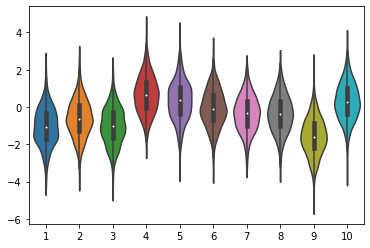

In [114]:
# meansdist = np.random.normal(0, 1, 10)
def generate_bandits():
    meansdist = np.random.normal(0, 1, 10)
    bandits = []
    for d in meansdist:
        new_bandit = Bandit(d)
        bandits.append(new_bandit)
    return bandits

array= generate_bandits()
rs = {}
for i in range(1000):
    b = Bandit(i)
    b.running_avg = i
    array.append(b)
for x in range(10):
    selected = array[x]
    a2 = []
    for y in range(1000):
        a2.append(selected.play())
    rs[x+1] = a2
    
df = pd.DataFrame(rs)
ax = sns.violinplot(data=df)

In [115]:
# establish the number of arms, steps and tasks


def run_experiment(steps, tasks, step_breaks, func):
    # set up the reward arrays for each epsilon
    greedy_r = np.zeros(steps)
    ep01_r = np.zeros(steps)
    ep1_r = np.zeros(steps)
    
    
    opt_greedy_r = np.zeros(steps)
    opt_ep01_r = np.zeros(steps)
    opt_ep1_r = np.zeros(steps)
    
    # set up data analysis for each epsilon
    step_data_dict = {
        'greedy' : BanditStepData.createDataDictForSteps(step_breaks),
        'e1' : BanditStepData.createDataDictForSteps(step_breaks),
        'e01' : BanditStepData.createDataDictForSteps(step_breaks)
    }
        
    for i in range(tasks):
        # create epsilon environments
        greedy = Environment(-1.0, steps, step_breaks)
        e1 = Environment(0.1, steps, step_breaks)
        e01 = Environment(0.01, steps, step_breaks)
    

        # play each unique set of bandits and return the avg result
        # func provides the bandits we want to test
        # returns the rewards and the played bandits
        r_g, g_step_data, g_optimal = greedy.run(func())
        r_e1, e1_step_data, e1_optimal = e1.run(func())
        r_e01, e01_step_data, e01_optimal = e01.run(func())
        
        greedy_data = step_data_dict['greedy']
        e1_data = step_data_dict['e1']
        e01_data = step_data_dict['e01']
        
        for sb in step_breaks:

            #------------- GREEDY DATA
            if greedy_data[sb].overal_running_avg < g_step_data[sb].overal_running_avg:
                greedy_data[sb].overal_running_avg = g_step_data[sb].overal_running_avg
                greedy_data[sb].ra_num = g_step_data[sb].ra_num
                
            if greedy_data[sb].overal_total_reward < g_step_data[sb].overal_total_reward:
                greedy_data[sb].overal_total_reward = g_step_data[sb].overal_total_reward
                greedy_data[sb].tr_num = g_step_data[sb].tr_num

                
            #------------- E1 DATA
            if e1_data[sb].overal_running_avg < e1_step_data[sb].overal_running_avg:
                e1_data[sb].overal_running_avg = e1_step_data[sb].overal_running_avg
                e1_data[sb].ra_num = e1_step_data[sb].ra_num                        
                
            if e1_data[sb].overal_total_reward < e1_step_data[sb].overal_total_reward:
                e1_data[sb].overal_total_reward = e1_step_data[sb].overal_total_reward
                e1_data[sb].tr_num = e1_step_data[sb].tr_num
                
            #------------- E01 DATA
            if e01_data[sb].overal_running_avg < e01_step_data[sb].overal_running_avg:
                e01_data[sb].overal_running_avg = e01_step_data[sb].overal_running_avg
                e01_data[sb].ra_num = e01_step_data[sb].ra_num
                
                
            if e01_data[sb].overal_total_reward < e01_step_data[sb].overal_total_reward:
                e01_data[sb].overal_total_reward = e01_step_data[sb].overal_total_reward
                e01_data[sb].tr_num = e01_step_data[sb].tr_num
                                
        # add results to the cumulative average array
        greedy_r = greedy_r + (r_g - greedy_r) / (i + 1)
        ep1_r = ep1_r + (r_e1 - ep1_r) / (i + 1)
        ep01_r = ep01_r + (r_e01 - ep01_r) / (i + 1)
        
        opt_greedy_r = opt_greedy_r + (g_optimal - opt_greedy_r) / (i + 1)
        opt_ep1_r = opt_ep1_r + (e1_optimal - opt_ep1_r) / (i + 1)
        opt_ep01_r = opt_ep01_r + (e01_optimal - opt_ep01_r) / (i + 1)

    return greedy_r, ep01_r, ep1_r, step_data_dict, [opt_greedy_r, opt_ep1_r, opt_ep01_r]


In [134]:
def createGraphs(greedy, ep1, ep01, start, ranges, title):
    fig, a = plt.subplots(figsize=(10,10))
    fig.suptitle(f"10 arm bandit {ranges[0]} steps")

#     for i in range(len(ranges)):
    r = ranges[0]
#     a = axs[math.floor(i/2),i%2]
    a.plot(greedy[start:r], label="greedy")
    a.plot(ep1[start:r], label="epsilon=0.01")
    a.plot(ep01[start:r], label="epsilon=0.1")
    a.set_title(f"{title} " + str(r) + " tasks")
    fig.legend(
        labels=["greedy", "epsilon=0.01", "epsilon=0.1"],
        loc="center right",
        borderaxespad=0.1)
#     plt.subplots_adjust(right=0.85)
#     for ax in a.flat:
#         ax.set(xlabel='Steps', ylabel='Average Reward')
#     plt.xscale('log')
    plt.show()


In [139]:
def create_data_table(data, steps):

    g_step_data = data['greedy'][steps[0]]
    e1_step_data = data['e1'][steps[0]]
    e01_step_data = data['e01'][steps[0]]
    print(f"FOR {steps} STEPS")
    print(f"for greedy, Max Avg was {g_step_data.overal_running_avg} on arm {g_step_data.ra_num}, Total Max as {g_step_data.overal_total_reward} on arm {g_step_data.tr_num}")
    print(f"for Epsilon 0.1, Max Avg was {e1_step_data.overal_running_avg} on arm {e1_step_data.ra_num}, Total Max as {e1_step_data.overal_total_reward} on arm {e1_step_data.tr_num}")
    print(f"for Epsilon 0.1, Max Avg was {e01_step_data.overal_running_avg} on arm {e01_step_data.ra_num}, Total Max as {e01_step_data.overal_total_reward} on arm {e01_step_data.tr_num}")
    print("\n")
#     fig = go.Figure(data=[go.Table(
#         header=dict(values=['Epsilon', 'Max Avg Arm #', 'Max Avg', 'Max Total Arm #', 'Max Total']),
#         cells=dict(values=[['greedy','e1','e01'], 
#                             [g_step_data.ra_num, e1_step_data.ra_num, e01_step_data.ra_num],
#                             [g_step_data.overal_running_avg, e1_step_data.overal_running_avg, e01_step_data.overal_running_avg],
#                             [g_step_data.tr_num, e1_step_data.tr_num, e01_step_data.tr_num],
#                             [g_step_data.overal_total_reward, e1_step_data.overal_total_reward, e01_step_data.overal_total_reward],
#                            ]))
#              ])
#     fig.update_layout(title_text = steps[0])
#     fig.show()

In [120]:
# run part 1
p1_g_1000, p1_e1_1000, p1_e01_1000, data_dict_1000, opt_1000 = run_experiment(1000, 1000, [1000], generate_bandits)
print('1 complete')
p1_g_3000, p1_e1_3000, p1_e01_3000, data_dict_3000, opt_3000 = run_experiment(3000, 1000, [3000], generate_bandits)
print('2 complete')
p1_g_4000, p1_e1_4000, p1_e01_4000, data_dic_4000, opt_4000 = run_experiment(4000, 1000, [4000], generate_bandits)
print('3 complete')
p1_g_7500, p1_e1_7500, p1_e01_7500, data_dict_7500, opt_7500 = run_experiment(7500, 1000, [7500], generate_bandits)

print('4 complete')

1 complete
2 complete
3 complete
4 complete


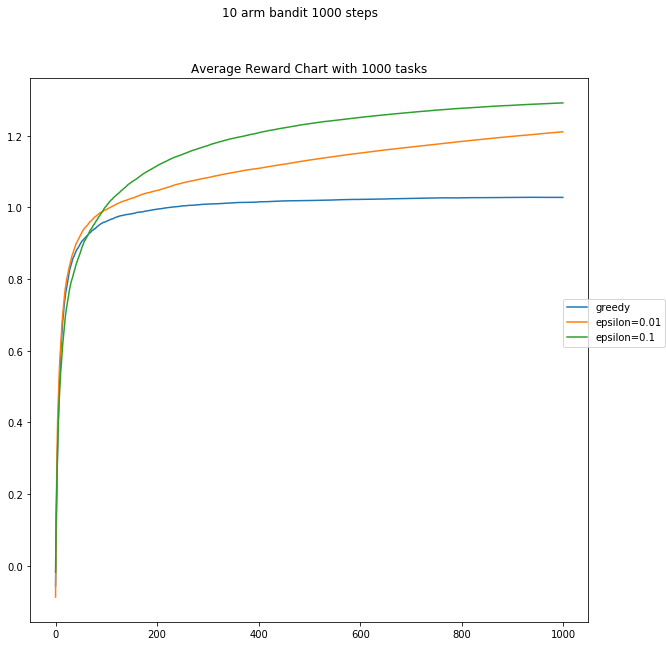

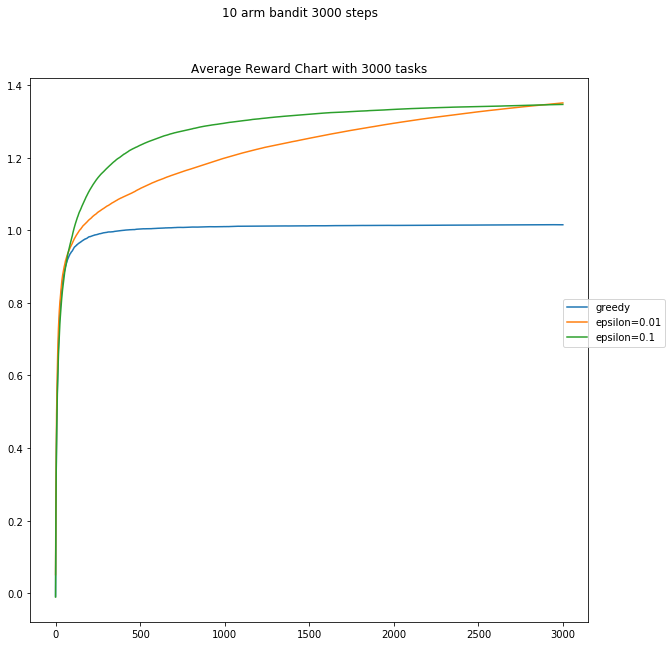

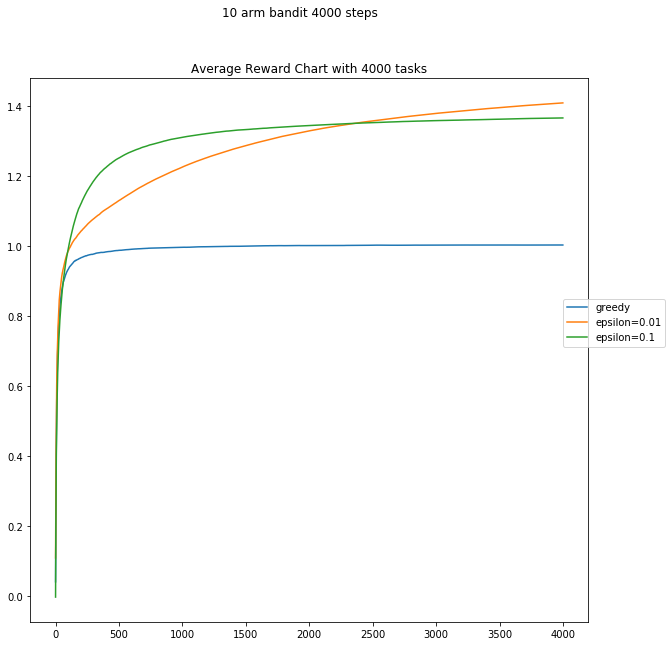

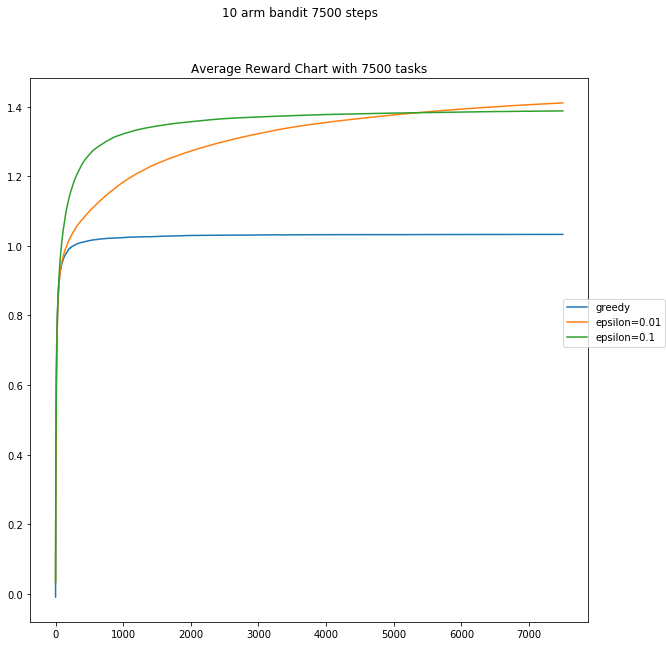

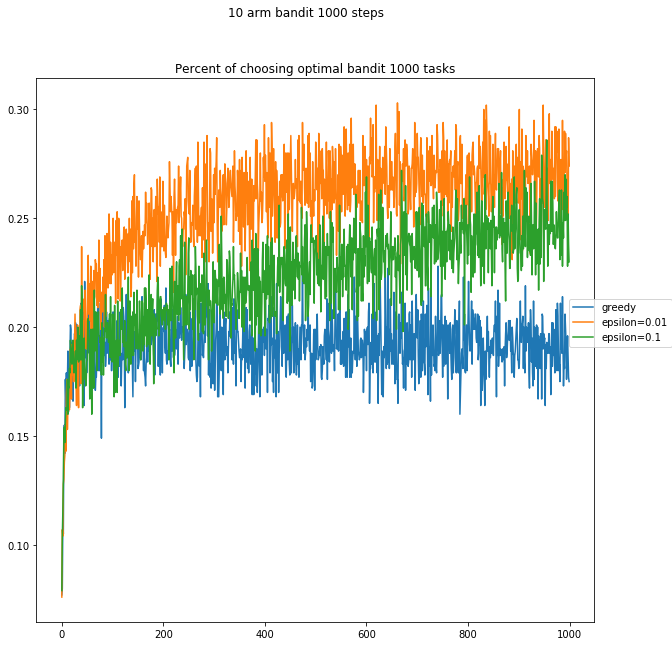

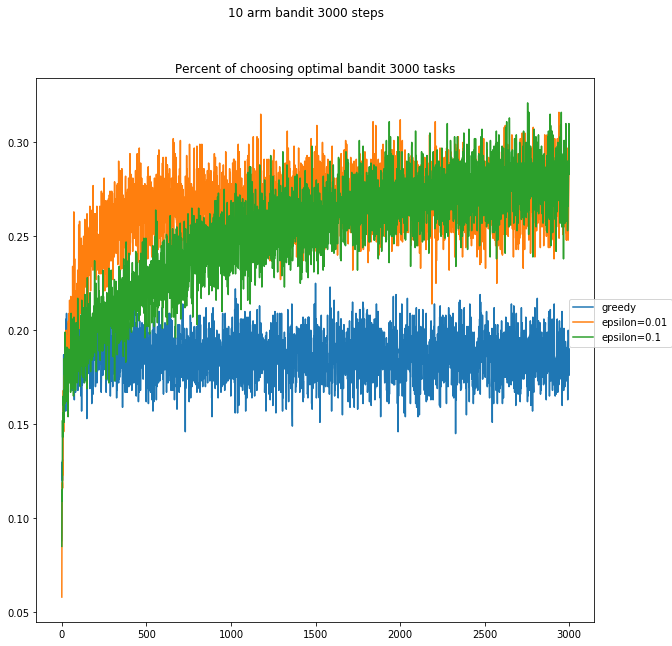

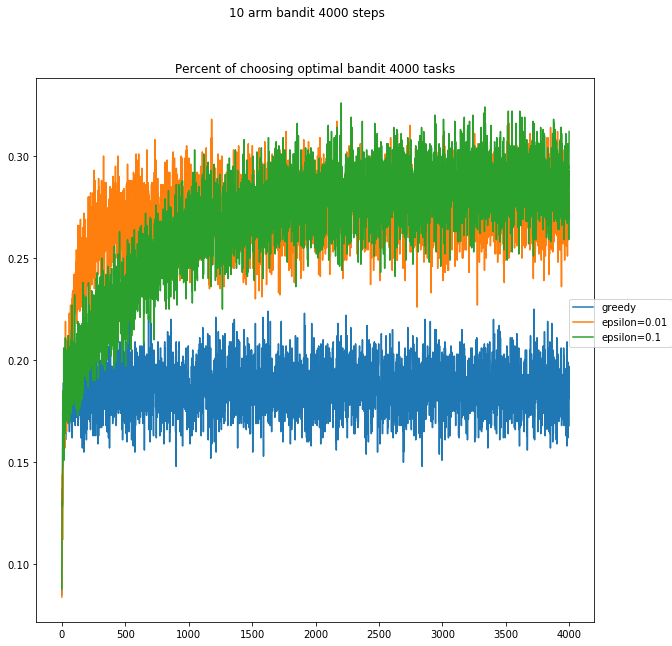

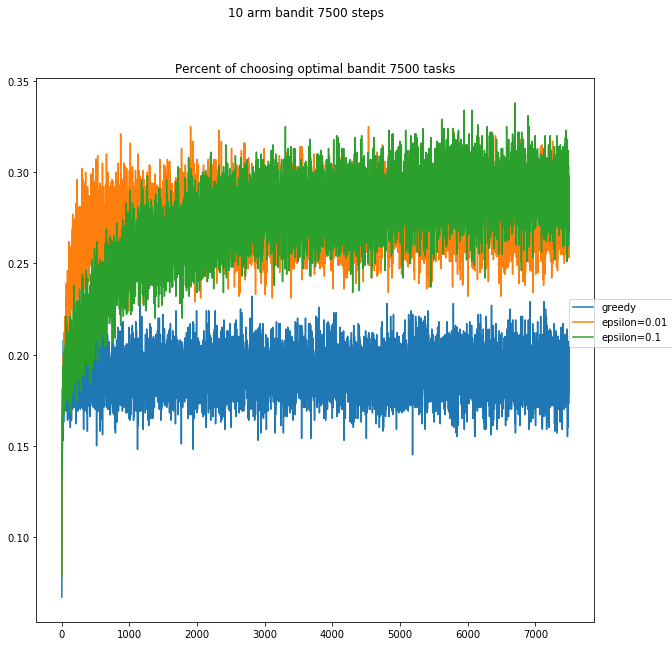

FOR [1000] STEPS
for greedy, Max Avg was 3.76 on arm 4, Total Max as 3743.07 on arm 4
for Epsilon 0.1, Max Avg was 4.04 on arm 4, Total Max as 3654.58 on arm 4
for Epsilon 0.1, Max Avg was 3.67 on arm 4, Total Max as 3629.82 on arm 4


FOR [3000] STEPS
for greedy, Max Avg was 3.79 on arm 4, Total Max as 11366.7 on arm 4
for Epsilon 0.1, Max Avg was 3.87 on arm 8, Total Max as 10517.58 on arm 8
for Epsilon 0.1, Max Avg was 3.95 on arm 5, Total Max as 10459.41 on arm 5


FOR [4000] STEPS
for greedy, Max Avg was 3.37 on arm 6, Total Max as 13480.09 on arm 6
for Epsilon 0.1, Max Avg was 3.79 on arm 6, Total Max as 13419.54 on arm 2
for Epsilon 0.1, Max Avg was 3.58 on arm 8, Total Max as 13901.61 on arm 2


FOR [7500] STEPS
for greedy, Max Avg was 3.7 on arm 8, Total Max as 27714.28 on arm 8
for Epsilon 0.1, Max Avg was 4.13 on arm 1, Total Max as 28151.55 on arm 1
for Epsilon 0.1, Max Avg was 3.58 on arm 8, Total Max as 25816.38 on arm 2




In [140]:
createGraphs(p1_g_1000, p1_e1_1000, p1_e01_1000, 0, [1000],"Average Reward Chart with")
createGraphs(p1_g_3000, p1_e1_3000, p1_e01_3000, 0, [3000], "Average Reward Chart with")
createGraphs(p1_g_4000, p1_e1_4000, p1_e01_4000, 0, [4000], "Average Reward Chart with")
createGraphs(p1_g_7500, p1_e1_7500, p1_e01_7500, 0, [7500], "Average Reward Chart with")


createGraphs(opt_1000[0], opt_1000[1], opt_1000[2], 0, [1000], "Percent of choosing optimal bandit")
createGraphs(opt_3000[0], opt_3000[1], opt_3000[2], 0, [3000], "Percent of choosing optimal bandit")
createGraphs(opt_4000[0], opt_4000[1], opt_4000[2], 0, [4000], "Percent of choosing optimal bandit")
createGraphs(opt_7500[0], opt_7500[1], opt_7500[2], 0, [7500], "Percent of choosing optimal bandit")

create_data_table(data_dict_1000,[1000])
create_data_table(data_dict_3000,[3000])
create_data_table(data_dic_4000,[4000])
create_data_table(data_dict_7500,[7500])

In [144]:
# load csv ad data for part 2
df = pd.read_csv('Ads_Optimisation.csv')
ad_array = df.to_numpy().transpose()


In [145]:
# create function to generate ad bandits for part 2

def generate_ad_bandits():
    ad_bandits = []
    for a in ad_array:
        new_ad_bandit = AdBandit(a.tolist())
        ad_bandits.append(new_ad_bandit)
    return ad_bandits


In [146]:

ap1_g_1000, ap1_e1_1000, ap1_e01_1000, a_data_dict_1000, _ = run_experiment(1000, 1000, [1000], generate_ad_bandits)

ap1_g_5000, ap1_e1_5000, ap1_e01_5000, a_data_dict_3000, _ = run_experiment(5000, 1000, [5000], generate_ad_bandits)

ap1_g_7500, ap1_e1_7500, ap1_e01_7500, a_data_dict_7500, _ = run_experiment(7500, 1000, [7500], generate_ad_bandits)

ap1_g_10000, ap1_e1_10000, ap1_e01_10000, a_data_dict_10000, _ = run_experiment(10000, 1000, [10000], generate_ad_bandits)


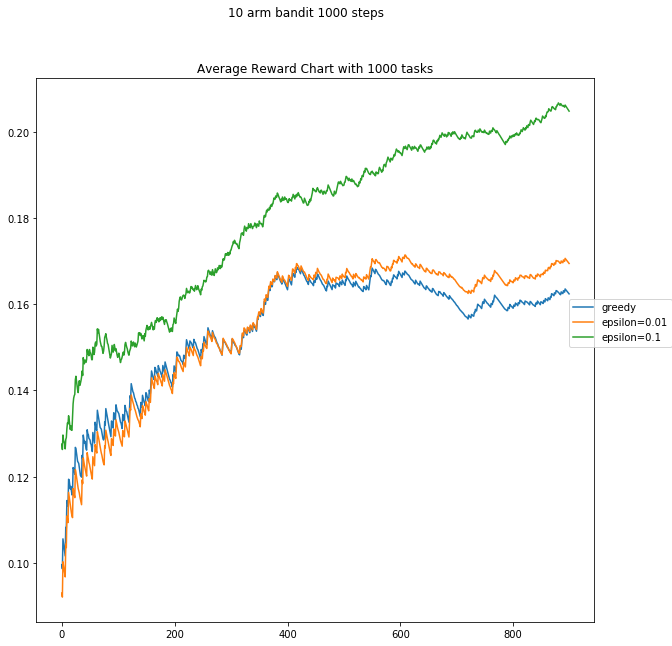

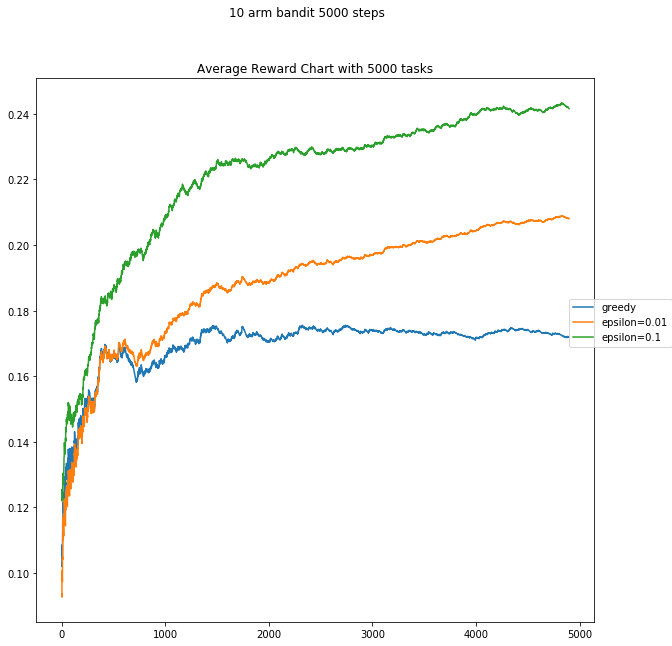

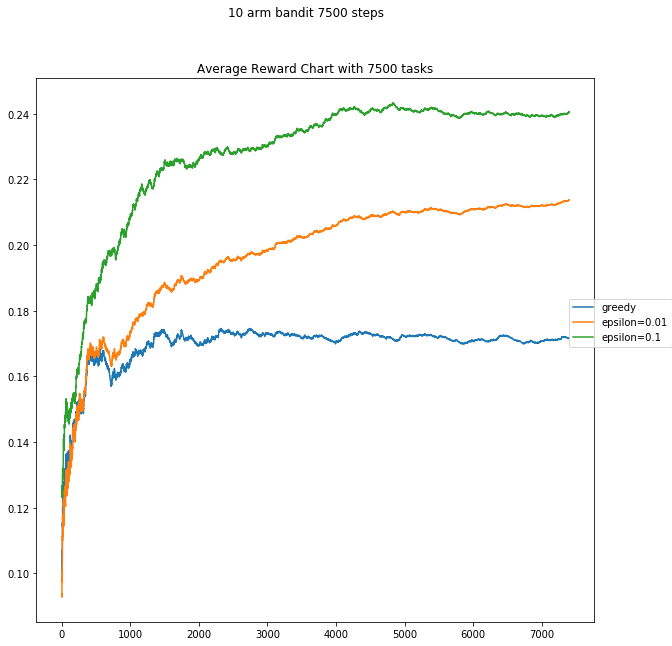

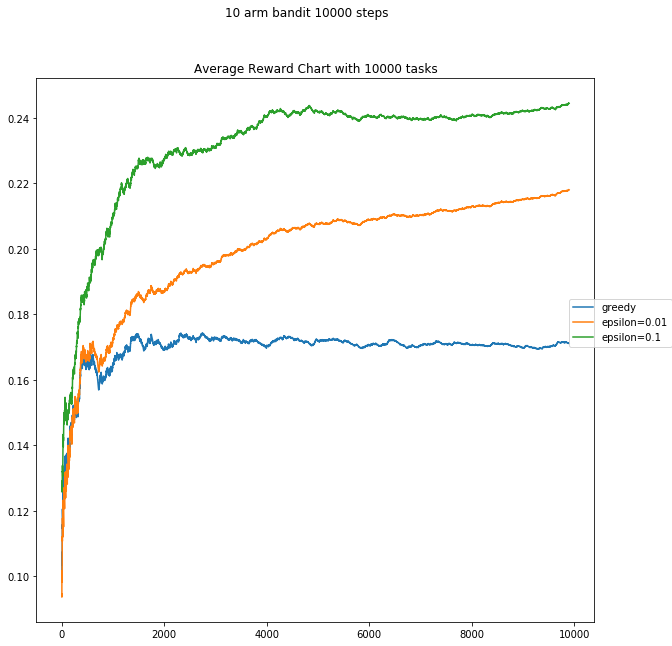

FOR [1000] STEPS
for greedy, Max Avg was 0.26 on arm 5, Total Max as 264 on arm 5
for Epsilon 0.1, Max Avg was 0.31 on arm 8, Total Max as 254 on arm 5
for Epsilon 0.1, Max Avg was 0.5 on arm 4, Total Max as 261 on arm 5


FOR [5000] STEPS
for greedy, Max Avg was 0.27 on arm 5, Total Max as 1372 on arm 5
for Epsilon 0.1, Max Avg was 0.29 on arm 5, Total Max as 1264 on arm 5
for Epsilon 0.1, Max Avg was 0.33 on arm 2, Total Max as 1358 on arm 5


FOR [7500] STEPS
for greedy, Max Avg was 0.27 on arm 5, Total Max as 2010 on arm 5
for Epsilon 0.1, Max Avg was 0.3 on arm 5, Total Max as 1853 on arm 5
for Epsilon 0.1, Max Avg was 0.38 on arm 5, Total Max as 1990 on arm 5


FOR [10000] STEPS
for greedy, Max Avg was 0.27 on arm 5, Total Max as 2695 on arm 5
for Epsilon 0.1, Max Avg was 0.29 on arm 5, Total Max as 2483 on arm 5
for Epsilon 0.1, Max Avg was 0.35 on arm 5, Total Max as 2672 on arm 5




In [147]:
createGraphs(ap1_g_1000, ap1_e1_1000, ap1_e01_1000, 100, [1000],"Average Reward Chart with")
createGraphs(ap1_g_5000, ap1_e1_5000, ap1_e01_5000, 100, [5000],"Average Reward Chart with")
createGraphs(ap1_g_7500, ap1_e1_7500, ap1_e01_7500, 100, [7500],"Average Reward Chart with")
createGraphs(ap1_g_10000, ap1_e1_10000, ap1_e01_10000, 100, [10000],"Average Reward Chart with")

create_data_table(a_data_dict_1000,[1000])
create_data_table(a_data_dict_3000,[5000])
create_data_table(a_data_dict_7500,[7500])
create_data_table(a_data_dict_10000,[10000])